<a href="https://colab.research.google.com/github/vsoos/colab/blob/main/5_1_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1 - Poetry/lyrics generator

*   The idea of this exercise project is to try out a few implementations of text generation AI and to compare their usefulness and discuss their limitations.
*   In this exercise, we might need to fix some details on the code examples in the articles so that they work with Google Colab, and with the current versions of TensorFlow, PyTorch or other modules
*   We will need kaggle.com for this exercise. If you don't have an account for it yet, create one before this exercise project (the account is free, you can use your school e-mail)



In [23]:
!pip install -q tensorflow

In [24]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from wordcloud import WordCloud
from keras import regularizers

In [25]:
folder_path = '/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex5/5_notebook1_gpu'
os.chdir(folder_path)

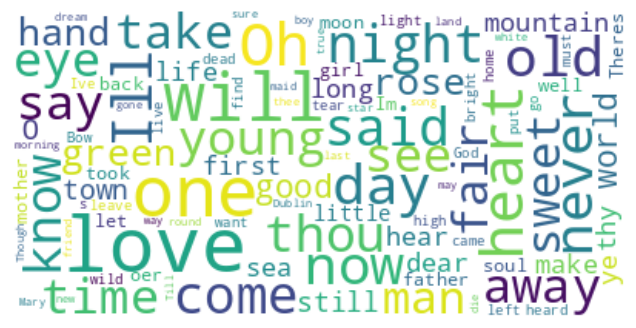

In [26]:
# Reading the text data file
data = open('poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="white").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [27]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [28]:
# Fitting the Tokenizer on the Corpus
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)

Total Words: 3807


In [29]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = tf.keras.utils.to_categorical(label, num_classes=total_words+1)

In [30]:
# Building a Bi-Directional LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(total_words + 1, 100, input_shape=(max_sequence_len - 1,)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense((total_words + 1) // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(total_words + 1, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 15, 100)             │         380,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 15, 300)             │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1904)                │         192,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3808)                │       7,254,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,288,944 (31.62 MB)

 Trainable params: 8,288,944 (31.62 MB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

In [32]:
history = model.fit(predictors, label, epochs=150, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 171s 203ms/step - accuracy: 0.0606 - loss: 7.4017 - learning_rate: 0.0010
Epoch 2/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.0623 - loss: 6.5247 - learning_rate: 0.0010
Epoch 3/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 146s 213ms/step - accuracy: 0.0648 - loss: 6.3369 - learning_rate: 0.0010
Epoch 4/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 138s 205ms/step - accuracy: 0.0686 - loss: 6.1988 - learning_rate: 0.0010
Epoch 5/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 158s 236ms/step - accuracy: 0.0767 - loss: 6.1192 - learning_rate: 0.0010
Epoch 6/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 129s 210ms/step - accuracy: 0.0897 - loss: 5.9887 - learning_rate: 0.0010
Epoch 7/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 113s 221ms/step - accuracy: 0.0953 - loss: 5.8661 - learning_rate: 0.0010
Epoch 8/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 137s 211ms/step - accuracy: 0.0973 - loss: 5.7827 - learning_rate: 0.0010
Epoch 9/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 142s 211ms/step - accuracy: 0.1085 - lo

In [33]:
seed_text = "The world"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = tf.keras.utils.pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print(seed_text)

The world it is ours her leaving at your heart day and i was born rose own came from his might meant a rose love it shall
